# Quantum Machine Learning for Satellite Data Analysis with Qiskit

HDCRS School, Day 2, Hands-on 2

## Setting up the environment


In [ ]:
github_repo_url = 'https://github.com/delilbasic/hdcrs-school-2025.git'
!git clone {github_repo_url}

import os

repo_folder_name = 'hdcrs-school-2025'
os.chdir(repo_folder_name)

!git clone https://github.com/alessandrosebastianelli/qml4eo_tutorial_qiskit.git
!bash install_requirements.sh

In [ ]:

!git clone https://github.com/alessandrosebastianelli/qml4eo_tutorial_qiskit.git
!bash install_requirements.sh

## Importing libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import minmax_scale
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
import qiskit_ibm_runtime
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy as np

In [ ]:
!pip list | grep "qiskit"

# Quantum Kernel Machine Learning

The general task of machine learning is to find and study patterns in data. For many datasets, the datapoints are better understood in a higher dimensional feature space. This is the fundamental principle behind a series of machine learning algorithms known as *kernel methods*.

In this section, you will learn how to define quantum kernels using `qiskit-machine-learning`.

## 1. Introduction

Kernel methods are a collection of pattern analysis algorithms that use kernel functions to operate in a high-dimensional feature space. The best-known application of kernel methods is in **Support Vector Machines (SVMs)**, supervised learning algorithms commonly used for classification tasks. The main goal of SVMs is to find decision boundaries to separate a given set of data points into classes. When these data spaces are not linearly separable, SVMs can benefit from the use of kernels to find these boundaries.

Formally, decision boundaries are hyperplanes in a high dimensional space. The kernel function implicitly maps input data into this higher dimensional space, where it can be easier to solve the initial problem. In other words, kernels may allow data distributions that were originally non-linearly separable to become a linearly separable problem. This is an effect known as the "kernel trick".

There are use-cases for kernel-based unsupervised algorithms too, for example, in the context of clustering. **Spectral Clustering** is a technique where data points are treated as nodes of a graph, and the clustering task is viewed as a graph partitioning problem where nodes are mapped to a space where they can be easily segregated to form clusters.

Mathematically, kernel functions follow:

$k(\vec{x}_i, \vec{x}_j) = \langle f(\vec{x}_i), f(\vec{x}_j) \rangle$

where
* $k$ is the kernel function
* $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs
* $f$ is a map from $n$-dimension to $m$-dimension space and
* $\langle a,b \rangle$ denotes the inner product

When considering finite data, a kernel function can be represented as a matrix:

$K_{ij} = k(\vec{x}_i,\vec{x}_j)$.

The main idea behind quantum kernel machine learning is to leverage quantum feature maps to perform the kernel trick. In this case, the quantum kernel is created by mapping a classical feature vector $\vec{x}$ to a Hilbert space using a quantum feature map $\phi(\vec{x})$. Mathematically:

$K_{ij} = \left| \langle \phi(\vec{x}_i)| \phi(\vec{x}_j) \rangle \right|^{2}$

where
* $K_{ij}$ is the kernel matrix
* $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs
* $\phi(\vec{x})$ is the quantum feature map
* $\left| \langle a|b \rangle \right|^{2}$ denotes the overlap of two quantum states $a$ and $b$

Quantum kernels can be plugged into common classical kernel learning algorithms such as SVMs or clustering algorithms. They can also be leveraged in new quantum kernel methods like [QSVC](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.algorithms.QSVC.html) class  provided by `qiskit-machine-learning`.

## 2. Classification

This section illustrates a quantum kernel classification workflow using `qiskit-machine-learning`.

### 2.1. Defining the dataset

For this example, we will use a cloud detection dataset, taking labeled pixels from the following image:

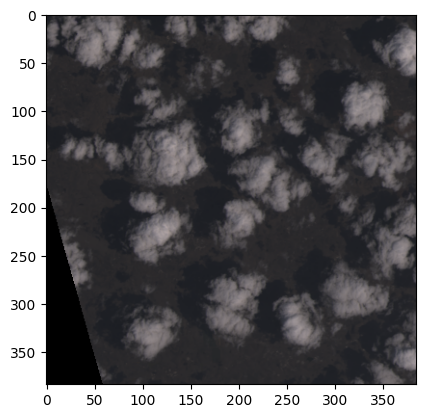

In [2]:
# Load and show image
clouds = plt.imread("clouds.png")
plt.imshow(clouds)

We selected 100 labeled pixels for training and testing. They are in `clouds.json`.

In [3]:
with open('clouds.json', 'r') as f:
    clouds_data = json.load(f)
x_full = np.array(clouds_data['x'])
y = np.array(clouds_data['y'])
print(x_full.shape, y.shape)

(100, 4) (100,)


**How do we visualize a 4-dimensional dataset?**

In [4]:
pca = PCA(n_components=2)
x = pca.fit_transform(x_full)

We have measurements for four wavelengths: blue (450-515 nm), green (520-600 nm), red (630-680 nm) and NIR (845-885 nm) with labels '0' (no-clouds) and '1' (clouds).

We need to scale the features to $[0, 2\pi]$ so that we can encode them as rotation gates.
We also create the train-test splits.

In [5]:
x = minmax_scale(x, (0,np.pi))
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

Let's plot it now:

Text(0.5, 1.0, 'Train-test split')

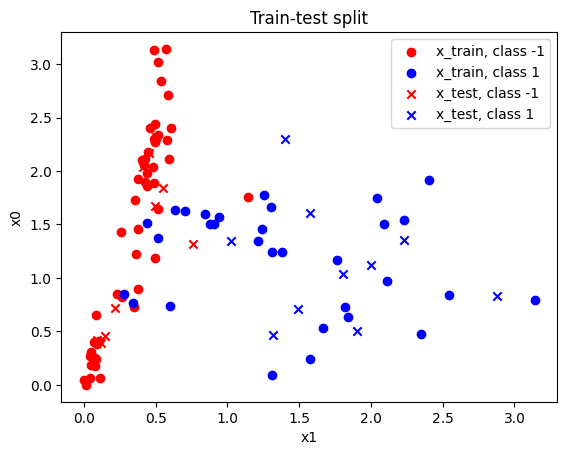

In [6]:
plt.scatter(*(x_train[y_train==-1].T), color='red', marker='o', label='x_train, class -1')
plt.scatter(*(x_train[y_train==1].T), color='blue', marker='o', label='x_train, class 1')
plt.scatter(*(x_test[y_test==-1].T), color='red', marker='x', label='x_test, class -1')
plt.scatter(*(x_test[y_test==1].T), color='blue', marker='x', label='x_test, class 1')
plt.legend()
plt.ylabel('x0')
plt.xlabel('x1')
plt.title('Train-test split')

### 2.2. Defining the quantum kernel

The next step is to create a quantum kernel instance that will help classify this data.

We use the [FidelityQuantumKernel](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.kernels.FidelityQuantumKernel.html) class, and pass a `feature_map`: in this case, a two-qubit [ZZFeatureMap](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ZZFeatureMap).


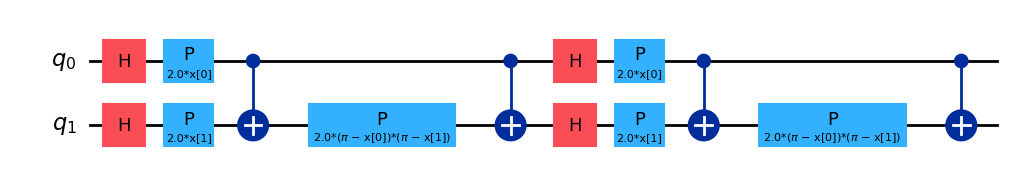

In [ ]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.circuit import ParameterVector

clouds_feature_map = ZZFeatureMap(feature_dimension=x_train.shape[1], reps=2, entanglement="linear")

clouds_kernel = FidelityQuantumKernel(feature_map=clouds_feature_map)

# To draw the full circuit with all gates, use the 'mpl' or 'text' drawer:
clouds_feature_map.decompose().draw('mpl')

### 2.3. Classification with SVC
The quantum kernel can now be plugged into classical kernel methods, such as the [SVC](https://scikit-learn.org/stable/modules/svm.html) algorithm from `scikit-learn`. This algorithm allows us to define a [custom kernel](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) in two ways:

1. by providing the kernel as a **callable function**
2. by precomputing the **kernel matrix**

#### Kernel as a callable function

We define a SVC model and directly pass the `evaluate` function of the quantum kernel as a callable. Once the model is created, we train it by calling the `fit` method on the training dataset and evaluate the model for accuracy with `score`.

In [ ]:
from sklearn.svm import SVC

clouds_svc = SVC(kernel=clouds_kernel.evaluate)


clouds_svc.fit(x_train, y_train)

clouds_score_callable_function = clouds_svc.score(x_test, y_test)

print(f"Callable kernel classification test score: {clouds_score_callable_function}")

#### Precomputed kernel matrix

Instead of passing a function of the quantum kernel as a callable, we can also precompute training and testing kernel matrices before passing them to the `scikit-learn` `SVC` algorithm.

To extract the train and test matrices, we can call `evaluate` on the previously defined kernel and visualize them graphically as follows:

In [ ]:
clouds_matrix_train = clouds_kernel.evaluate(x_vec=x_train)
clouds_matrix_test = clouds_kernel.evaluate(x_vec=x_train, y_vec=x_test)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(clouds_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Clouds training kernel matrix")

axs[1].imshow(np.asmatrix(clouds_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Clouds testing kernel matrix")

plt.show()

To use these matrices, we set the `kernel` parameter of a new `SVC` instance to `"precomputed"`. We train the classifier by calling `fit` with the training matrix and training dataset. Once the model is trained, we evaluate it using the test matrix on the test dataset.

In [ ]:
clouds_svc = SVC(kernel="precomputed")

clouds_svc.fit(clouds_matrix_train, y_train)

clouds_score_precomputed_kernel = clouds_svc.score(clouds_matrix_test.T, y_test)

print(f"Precomputed kernel classification test score: {clouds_score_precomputed_kernel}")

### 2.4. Classification with QSVC

`QSVC` is an alternative training algorithm provided by `qiskit-machine-learning` for convenience. It is an extension of `SVC` that takes in a quantum kernel instead of the `kernel.evaluate` method shown before.

In [30]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=clouds_kernel)

qsvc.fit(x_train, y_train)

qsvc_score = qsvc.score(x_test, y_test)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 0.55


Text(0.5, 0, 'x1')

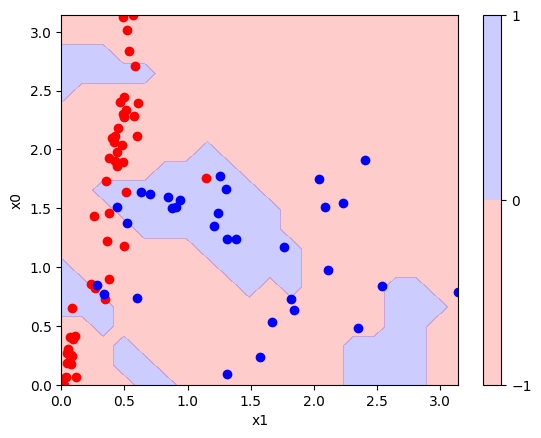

In [31]:
N_gridpoints = 20
_xx, _yy = np.meshgrid(np.linspace(0, np.pi, N_gridpoints), np.linspace(0, np.pi, N_gridpoints))

_zz = np.zeros_like(_xx)
for idx in np.ndindex(*_xx.shape):
    _zz[idx] = qsvc.predict(np.array([_xx[idx], _yy[idx]])[np.newaxis, :])[0]

plot_data = {"_xx": _xx, "_yy": _yy, "_zz": _zz}
plt.contourf(
    _xx,
    _yy,
    _zz,
    alpha=0.2,
    levels=[-1, 0, 1],
    colors=['red','blue']
)
plt.colorbar()
plt.scatter(*(x_train[y_train==-1].T), color='red')
plt.scatter(*(x_train[y_train==1].T), color='blue')
plt.ylabel('x0')
plt.xlabel('x1')

### 2.5 Comparison with RBF kernel

In [ ]:
clouds_svc_rbf = SVC(kernel='rbf', gamma='scale')
clouds_svc_rbf.fit(x_train, y_train)
clouds_score_rbf = clouds_svc_rbf.score(x_test, y_test)

N_gridpoints = 20
_xx, _yy = np.meshgrid(np.linspace(0, np.pi, N_gridpoints), np.linspace(0, np.pi, N_gridpoints))

_zz = np.zeros_like(_xx)
for idx in np.ndindex(*_xx.shape):
    _zz[idx] = clouds_svc_rbf.predict(np.array([_xx[idx], _yy[idx]])[np.newaxis, :])[0]

plot_data = {"_xx": _xx, "_yy": _yy, "_zz": _zz}
plt.contourf(
    _xx,
    _yy,
    _zz,
    alpha=0.2,
    levels=[-1, 0, 1],
    colors=['red','blue']
)
plt.colorbar()
plt.scatter(*(x_train[y_train==-1].T), color='red')
plt.scatter(*(x_train[y_train==1].T), color='blue')
plt.ylabel('x0')
plt.xlabel('x1')

In [ ]:
print(f"Classification Model                    | Accuracy Score")
print(f"---------------------------------------------------------")
print(f"SVC using kernel as a callable function | {clouds_score_callable_function:10.2f}")
print(f"SVC using precomputed kernel matrix     | {clouds_score_precomputed_kernel:10.2f}")
print(f"QSVC                                    | {qsvc_score:10.2f}")
print(f"SVC with RBF kernel                     | {clouds_score_rbf:10.2f}")

### 2.6 Trainable Quantum Kernel

The results are not satisfactory with ZZFeatureMap. Let's add a trainable data encoding layer and see what happens.

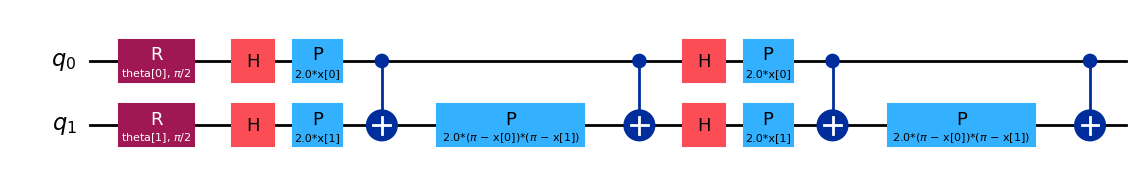

In [20]:
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel

theta = ParameterVector('theta', length=x_train.shape[1])

feature_map = QuantumCircuit(x_train.shape[1])
feature_map.ry(theta[0], 0)
feature_map.ry(theta[1], 1)
feature_map = feature_map.compose(clouds_feature_map, inplace=False)

kernel = TrainableFidelityQuantumKernel(
    feature_map=feature_map,
    training_parameters=theta
)

feature_map.decompose().draw('mpl')


In [ ]:
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.utils.loss_functions import SVCLoss

spsa_opt = SPSA(maxiter=10, learning_rate=0.03, perturbation=0.01)
loss_func = SVCLoss(C=1.0)
qkt = QuantumKernelTrainer(
                           quantum_kernel=kernel,
                           loss=loss_func,
                           optimizer=spsa_opt,
                           initial_point = np.full(len(theta), np.pi/2),
       )


In [25]:
results = qkt.fit(x_train, y_train)
optimized_kernel = results.quantum_kernel

In [27]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=optimized_kernel)

qsvc.fit(x_train, y_train)

qsvc_score = qsvc.score(x_test, y_test)

print(f"QSVC with trainable kernel classification test score: {qsvc_score}")

QSVC with trainable kernel classification test score: 0.55


Text(0.5, 0, 'x1')

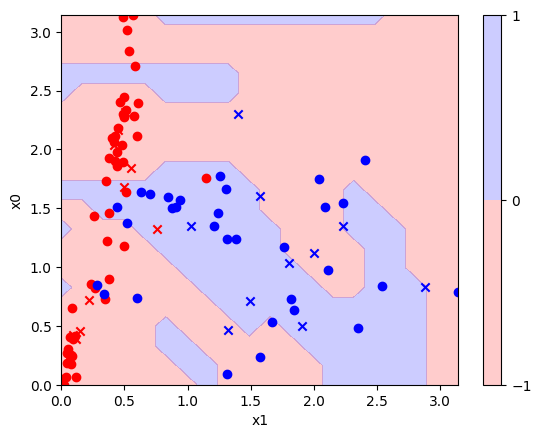

In [29]:
N_gridpoints = 20
_xx, _yy = np.meshgrid(np.linspace(0, np.pi, N_gridpoints), np.linspace(0, np.pi, N_gridpoints))

_zz = np.zeros_like(_xx)
for idx in np.ndindex(*_xx.shape):
    _zz[idx] = qsvc.predict(np.array([_xx[idx], _yy[idx]])[np.newaxis, :])[0]

plot_data = {"_xx": _xx, "_yy": _yy, "_zz": _zz}
plt.contourf(
    _xx,
    _yy,
    _zz,
    alpha=0.2,
    levels=[-1, 0, 1],
    colors=['red','blue']
)
plt.colorbar()
plt.scatter(*(x_train[y_train==-1].T), color='red', marker='o', label='x_train, class -1')
plt.scatter(*(x_train[y_train==1].T), color='blue', marker='o', label='x_train, class 1')
plt.scatter(*(x_test[y_test==-1].T), color='red', marker='x', label='x_test, class -1')
plt.scatter(*(x_test[y_test==1].T), color='blue', marker='x', label='x_test, class 1')
plt.ylabel('x0')
plt.xlabel('x1')

## Hybrid Quantum-Classical Neural Network for Satellite Image Classification

Adapted from `https://github.com/alessandrosebastianelli/qml4eo_tutorial_qiskit.git`.

Please refer to the following articles to get more insight about this topic:

[1] Sebastianelli, A., Zaidenberg, D. A., Spiller, D., Le Saux, B., & Ullo, S. L. (2021). On circuit-based hybrid quantum neural networks for remote sensing imagery classification. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 15, 565-580.
[2] Zaidenberg, D. A., Sebastianelli, A., Spiller, D., Le Saux, B., & Ullo, S. L. (2021, July). Advantages and bottlenecks of quantum machine learning for remote sensing. In 2021 IEEE International Geoscience and Remote Sensing Symposium IGARSS (pp. 5680-5683). IEEE.
[3] Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. Patrick Helber, Benjamin Bischke, Andreas Dengel, Damian Borth. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2019.
[4] Introducing EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. Patrick Helber, Benjamin Bischke, Andreas Dengel. 2018 IEEE International Geoscience and Remote Sensing Symposium, 2018.


In [14]:
os.chdir('qml4eo_tutorial_qiskit')

from hybrid_model import *
from torch_loader import EuroSATDataModule

torch.multiprocessing.set_start_method('spawn')  
torch.set_float32_matmul_precision('high')

RuntimeError: context has already been set

### Download the dataset

In this study, we address the challenge of land use and land cover classification using Sentinel-2 satellite images. The Sentinel-2 satellite images are openly and freely accessible provided in the Earth observation program Copernicus. We present a novel dataset based on Sentinel-2 satellite images covering 13 spectral bands and consisting out of 10 classes with in total 27,000 labeled and geo-referenced images. We provide benchmarks for this novel dataset with its spectral bands using state-of-the-art deep Convolutional Neural Network (CNNs). With the proposed novel dataset, we achieved an overall classification accuracy of 98.57%. The resulting classification system opens a gate towards a number of Earth observation applications. We demonstrate how this classification system can be used for detecting land use and land cover changes and how it can assist in improving geographical maps.

Get more information [here](https://github.com/phelber/EuroSAT).

![](https://github.com/phelber/EuroSAT/blob/master/eurosat_overview_small.jpg?raw=true)

The following snippet will download the EuroSAT dataset and split it in train/validation/test sub-datasets.

In [ ]:
!bash download_data.sh

### Load data

In [ ]:

# This is the full list of classes in EuroSAT
classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture','PermanentCrop', 'Residential', 'River', 'SeaLake']

# For simplicity we will reduce them to 2
classes = ['Forest', 'Highway']

# Torch lightning data loader module
data_module = EuroSATDataModule(
        whitelist_classes = classes, # Here we are selecting the classes to be classified
        root_dir          = '/content',      
        batch_size        = 16, 
        bands             = [3,2,1], # Here we are selecting only the RGB bands
        num_workers       = 4,
)
     

### Plot some data

In [ ]:
data_module.setup()
loader = data_module.train_dataloader()
x, y = next(iter(loader))

fig, axes = plt.subplots(nrows=4, ncols=4)
axes = axes.flatten()


x = x.cpu().detach().numpy()
x = np.moveaxis(x, 1, -1)


for i, ax in enumerate(axes):
    ax.imshow(x[i,...])
    ax.axis(False)

fig.tight_layout()
plt.show()

### Run Hybrid model


The method proposed in [1] introduces a hybrid quantum-classical convolutional neural network (QCNN) designed for remote sensing image classification, specifically applied to land-use and land-cover (LULC) classification using the EuroSAT dataset.

The architecture integrates a quantum circuit layer into a classical CNN (based on a modified LeNet-5), with quantum layers implemented using different types of gate-based circuits, including both entangled and non-entangled designs. Classical data are first embedded into quantum states via unitary transformations, enabling the quantum circuit to process them through parametrized gates.

With respect to [1], here we are going to use a more "complex" classical deep learning network.

In [ ]:

number_of_qubits = 2 # Feel free to "play" with this parameter
network = LightningAlexNetModule(n_qubits=number_of_qubits, num_classes=len(classes))
log_name  = 'hybrid_model'

# will log some relevant information about training/validation/testing of the model
tb_logger = pl.loggers.TensorBoardLogger(os.path.join('lightning_logs','classifiers'), name=log_name)

# will save models weights
checkpoint_callback = ModelCheckpoint(
    dirpath         = os.path.join('saved_models','classifiers'),
    filename        = log_name,
    monitor         = 'val_loss',
    save_top_k      = 1,
    mode            = 'min',
)

# Instantiate Trainer
trainer = pl.Trainer(max_epochs=30, callbacks=[checkpoint_callback], logger=tb_logger)

# Train the model
trainer.fit(network, data_module)